# Advance Lane Finding 

In this project I explore traditional computer vision techniques and create a program which tracks the lane lines in video footage taken from the front of a car.

software requirements:
 * python3
 * openCV
 * numpy


## 1. camera calibration 

When a camera looks at 3D objects in the real world and transforms them into 2D images, a certain amount of information from the world gets distorted due to various factors such as lens curvature etc. We need to correct images taken from the camera by using a distortion matrix before information from the camera images can be used reliably.

A reliable way to calibrate the camera images is to use objects whose (x, y, z) coordinates with respect to the camera are known and correct for the same points on the camera images. To facilitate this idea we can use images of chessboard surfaces where the number of black/white box corners are known to be at a constant space from each other and the z coordinates lie on a flat plane.

The openCV library contains an utility function called ``` find_chessboard_images``` which can be used to determine the coordinates of the points on a given image of a chessboard.
The openCV library also contains an utility function called ```calibrateCamera``` which takes a set of image points and a set of object points and returns the distortion matrix along with other useful tranformation matrices.

I use the ```find_chessboard_images``` functions to determine the corners of chessboard images and generate object points which can be used to find the matrix.

This process is encapsulated in a class called ```Calibrator``` which is initialized in the beginning of the program and contains the undistort method which consistently undistorts images from the camera used to record the footage.

In [1]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from components.calibrator import Calibrator
import cv2
import numpy as np
import glob


def display_original_and_transformed(image, 
                                     transormation_function, 
                                     transormation_title='transformed',
                                     color_convert_transformed=True, 
                                     color_transform=cv2.COLOR_BGR2RGB):
    
    original = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transormed = transormation_function(image)
    if color_convert_transformed:
        transormed = cv2.cvtColor(transormed, color_transform)
    figure = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(1, 2, top=1., bottom=0., right=0.8, left=0., hspace=0.,
        wspace=0.5)
    
    ax = plt.subplot(gs[0])
    plt.imshow(original)
    ax.axis("off")
    ax.set_title('original image')
    
    ax2 = plt.subplot(gs[1])
    plt.imshow(transormed)
    ax2.axis("off")
    ax2.set_title(transormation_title)

In [2]:
chessboard_image_sources = glob.glob('camera_cal/calibration*.jpg')
chessboard_images = [cv2.imread(filename) for filename in chessboard_image_sources]
calibrator = Calibrator(chessboard_images)

demonstration of test calibration results

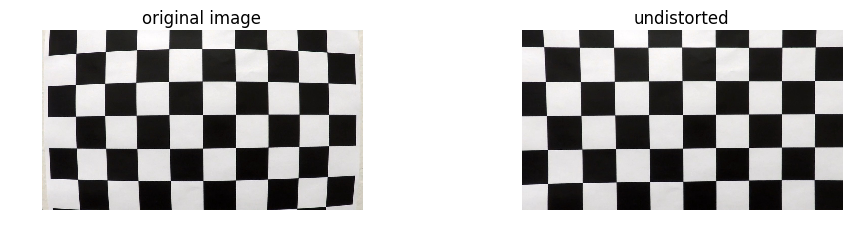

In [3]:
display_original_and_transformed(chessboard_images[0], calibrator.undistort, 'undistorted')

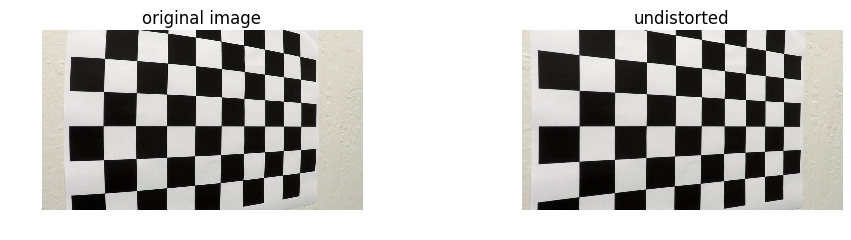

In [4]:
display_original_and_transformed(chessboard_images[15], calibrator.undistort, 'undistorted')

now that we know the calibration is working, lets apply it to the test image

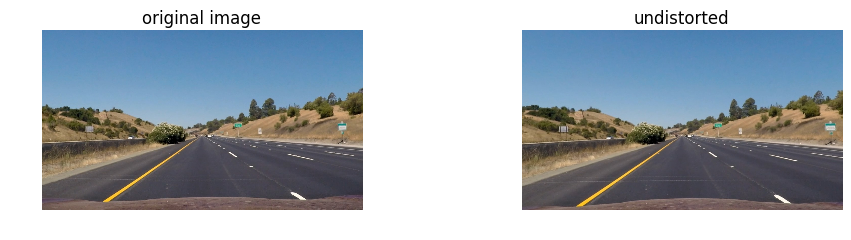

In [5]:
test_image_file = 'test_images/straight_lines1.jpg'
test_image = cv2.imread(test_image_file)
display_original_and_transformed(test_image, calibrator.undistort, 'undistorted')

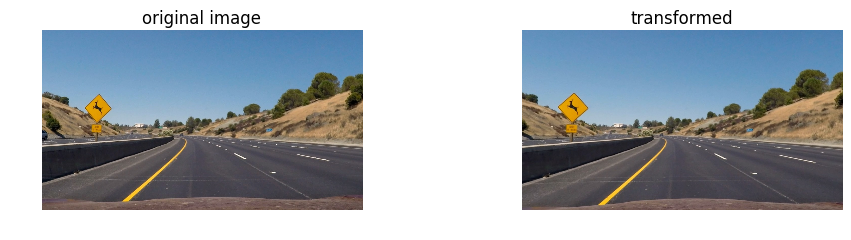

In [6]:
test_image_file = 'test_images/test2.jpg'
test_image = cv2.imread(test_image_file)
display_original_and_transformed(test_image, calibrator.undistort)

In [7]:
from components.region_selector import RegionSelector

In [8]:
region_selector = RegionSelector()

In [9]:
def interactive_region_select(bottom_y, top_y, center_x, bottom_width, top_width, image):
    updated_image = region_selector.update_and_show(
        bottom_y,
        top_y,
        center_x,
        bottom_width,
        top_width,
        image
    )
    plt.imshow(updated_image)

<function __main__.interactive_region_select>

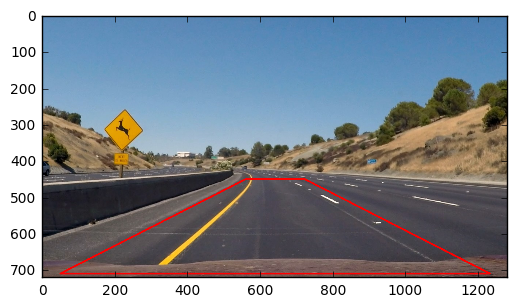

In [10]:
from ipywidgets import interact, fixed, IntSlider
interact(
    interactive_region_select,
    bottom_y = IntSlider(min=0,max=750,step=10,value=710),
    top_y = IntSlider(min=0,max=750,step=10,value=450),
    center_x = IntSlider(min=0,max=1280,step=10,value=640),
    bottom_width = IntSlider(min=0,max=640,step=10,value=590),
    top_width = IntSlider(min=0,max=640,step=10,value=80),
    image=fixed(test_image))
    